# US 2022 Stock Market Analysis

In this notebook, I will attempt to investigate how the various sectors performed on the stock market in 2022 by creating a market cap-weighted index of each sector, and plotting its returns over the year.

The stocks are classified into sectors according to the Global Industry Classificaiton  Standard (GICS):
- Communication Services
- Consumer Discretionary
- Consumer Staples
- Energy
- Financials
- Healthcare
- Industrials 
- Information Technology
- Materials
- Real Estate
- Utilities


In [1]:
import yfinance as yf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

### Downloading stock data

I first had to get a table of all the stocks currently trading in the US. I downloaded the data below from the [NASDAQ Stock Screener](https://www.nasdaq.com/market-activity/stocks/screener).

In [2]:
# Data from NASDAQ stock screener
us_stocks = pd.read_csv('us_stocks.csv')

In [3]:
us_stocks

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector
0,0,0,0.0,0.0,A,Agilent Technologies Inc. Common Stock,3.496068e+10,Industrials
1,1,1,1.0,1.0,AA,Alcoa Corporation Common Stock,6.090627e+09,Industrials
2,2,2,2.0,2.0,AACI,Armada Acquisition Corp. I Common Stock,0.000000e+00,Financials
3,3,3,3.0,4.0,AADI,Aadi Bioscience Inc. Common Stock,1.551749e+08,Healthcare
4,4,4,4.0,5.0,AAIC,Arlington Asset Investment Corp Class A (new),1.296073e+08,Real Estate
...,...,...,...,...,...,...,...,...
5056,5056,5056,5056.0,5798.0,ZYXI,Zynex Inc. Common Stock,3.364970e+08,Healthcare
5057,5057,5335,NaN,NaN,NaN,NaN,3.316515e+08,Industrials
5058,5058,5456,NaN,NaN,NaN,NaN,3.316515e+08,Information Technology
5059,5059,5625,NaN,NaN,NaN,NaN,3.316515e+08,Consumer Discretionary


In [4]:
us_stock_ticker_symbols = us_stocks['Symbol']

Next, I downloaded the 2022 price history of each stock, saving each in its own file in the folder `us_stocks`.
This price data is from [Yahoo Finance](https://finance.yahoo.com), accessed through the `yfinance` library.

In [5]:
tickers_loaded = []
tickers_not_loaded = []
for i in us_stock_ticker_symbols:
    ticker = i.replace('^', '-P')
    # Make sure there is no error associated with downloading the stock data
    try:
        data = yf.download(ticker, start='2022-01-01', end='2022-12-31')
    except:
        tickers_not_loaded += [ticker]
        continue
    # Make sure ticker was traded on all trading days in 2022
    # Also takes care of tickers that failed to download but did not raise an exception
    if len(data) != 251:
        tickers_not_loaded += [ticker]
        continue
    # / character is not allowed in file names
    file_name = ticker.replace('/','{slash}')
    data.to_csv(f'stock_data/{file_name}.csv')
    tickers_loaded += [ticker]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


1 Failed download:
['BGRYW']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2022-12-31)')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

AttributeError: 'float' object has no attribute 'replace'

In [7]:
# Data of tickers that managed to load and tickers that did not. Needs to be changed to DataFrame to make using it easier
tickers_loaded = pd.DataFrame(tickers_loaded, columns=['Symbol'])
tickers_not_loaded = pd.DataFrame(tickers_not_loaded, columns=['Symbol'])

"tickers_not_loaded = []\nfor i in us_stock_ticker_symbols:\n    ticker = i.replace('^','-P').replace('/','{slash}')\n    if not os.path.isfile(f'stock_data/{ticker}.csv'):\n        tickers_not_loaded += [ticker]"

I need to replace '^' (found in NASDAQ stock tickers) with '-P' (found in Yahoo finance stock tickers). I also need to replace any '/' found in the ticker name with '{slash}' (as / is not allowed in file name)>

In [9]:
us_stocks['Symbol'] = us_stocks['Symbol'].replace({'\^': '-P'}, regex=True)
us_stocks['Symbol'] = us_stocks['Symbol'].replace({'/': '{slash}'}, regex=True)

### Cleaning up data (mostly renaming of Sectors

In this section, I clean up the data, making sure each stock has a Sector and Market Cap, and the Sector names are in line with the Global Industry Classification Standard (GICS).

In [11]:
# The breakdown of sectors according to NASDAQ
sectors = pd.DataFrame(us_stocks.groupby('Sector').count().index)

In [12]:
sectors

,Sector
0,Communication Services
1,Consumer Discretionary
2,Consumer Staples
3,Energy
4,Financials
5,Healthcare
6,Industrials
7,Information Technology
8,Materials
9,Real Estate


In [13]:
us_stocks[us_stocks['Sector']=='Miscellaneous']

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector


In [14]:
indexes_to_drop = list(us_stocks[us_stocks['Symbol'].isin(tickers_not_loaded['Symbol'])].index)

In [15]:
us_stocks.drop(indexes_to_drop, inplace=True)

In [16]:
# checking which tickers have a sector marked as Miscellaneous
us_stocks[us_stocks['Sector']=='Miscellaneous']

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector


In [17]:
# checking which ickers have missing sectors
us_stocks[us_stocks['Sector'].isna()]

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector


In [18]:
# Attempt to assign sector to tickers that have no sector
for i in range(len(us_stocks)):
    if pd.isnull(us_stocks.iloc[i]['Sector']):
        # check if it is a variant of an existing stock
        if ('-P' in us_stocks.iloc[i]['Symbol']) & (us_stocks.iloc[i]['Symbol'].split('-')[0] in us_stocks['Symbol'].values ):
            us_stocks.at[i,'Sector'] = str(us_stocks[us_stocks['Symbol']==us_stocks.iloc[i]['Symbol'].split('-')[0]]['Sector'].values[0])
            continue

        # get  sector classification from yahoo finance
        stock_yf_data = yf.Ticker(us_stocks.iloc[i]['Symbol']).info
        if 'sector' in stock_yf_data.keys():
            us_stocks.at[i,'Sector'] = stock_yf_data['sector']



In [19]:
# The stocks with sectors still missing
us_stocks[us_stocks['Sector'].isna() | us_stocks['Sector']=='Miscellaneous']

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector


In [20]:
# Mannually replacing the remaining missing sectors
us_stocks.at[83,'Sector'] = 'Industrials'
us_stocks.at[102,'Sector'] = 'Utilities' # check if this is true
us_stocks.at[292,'Sector'] = 'Finance'
us_stocks.at[391,'Sector'] = 'Technology'
us_stocks.at[498,'Sector'] = 'Industrials'
us_stocks.at[639,'Sector'] = 'Consumer Discretionary'
us_stocks.at[931,'Sector'] = 'Industrials'
us_stocks.at[1120,'Sector'] = 'Consumer Discretionary'
us_stocks.at[1774,'Sector'] = 'Industrials'
us_stocks.at[1787,'Sector'] = 'Industrials'
us_stocks.at[1794,'Sector'] = 'Industrials'
us_stocks.at[1795,'Sector'] = 'Industrials'
us_stocks.at[2033,'Sector'] = 'Utilities'
us_stocks.at[2039,'Sector'] = 'Industrials'
us_stocks.at[2093,'Sector'] = 'Consumer Discretionary'
us_stocks.at[2094,'Sector'] = 'Consumer Discretionary'
us_stocks.at[2402,'Sector'] = 'Industrials'
us_stocks.at[2887,'Sector'] = 'Health Care'
us_stocks.at[2958,'Sector'] = 'Health Care'
us_stocks.at[3050,'Sector'] = 'Consumer Discretionary'
us_stocks.at[3058,'Sector'] = 'Health Care'
us_stocks.at[3571,'Sector'] = 'Technology'
us_stocks.at[3592,'Sector'] = 'Industrials'
us_stocks.at[3621,'Sector'] = 'Consumer Discretionary'
us_stocks.at[3692,'Sector'] = 'Utilities'
us_stocks.at[3721,'Sector'] = 'Industrials'
us_stocks.at[3758,'Sector'] = 'Industrials'
us_stocks.at[3968,'Sector'] = 'Technology'
us_stocks.at[3993,'Sector'] = 'Industrials'
us_stocks.at[4186,'Sector'] = 'Industrials'
us_stocks.at[4542,'Sector'] = 'Technology'
us_stocks.at[4612,'Sector'] = 'Consumer Discretionary'
us_stocks.at[4874,'Sector'] = 'Consumer Staples'
us_stocks.at[4986,'Sector'] = 'Technology'
us_stocks.at[5335,'Sector'] = 'Industrials'
us_stocks.at[5456,'Sector'] = 'Technology'
us_stocks.at[5625,'Sector'] = 'Consumer Discretionary'
us_stocks.at[5716,'Sector'] = 'Consumer Discretionary'
us_stocks.at[99,'Sector'] = 'Financials'
us_stocks.at[121,'Sector'] = 'Financials'
us_stocks.at[1286,'Sector'] = 'Energy'
us_stocks.at[1593,'Sector'] = 'Utilities'
us_stocks.at[2529,'Sector'] = 'Financials'
us_stocks.at[3163,'Sector'] = 'Utilities'
us_stocks.at[3296,'Sector'] = 'Financials'
us_stocks.at[3297,'Sector'] = 'Financials'
us_stocks.at[4018,'Sector'] = 'Utilities'
us_stocks.at[4021,'Sector'] = 'Utilities'
us_stocks.at[4022,'Sector'] = 'Financials'

In [21]:
us_stocks[us_stocks['Sector'].isna() | us_stocks['Sector']=='Miscellaneous']  # This confirms that no ticker has a missing sector

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector


In [22]:
sectors = pd.Series(us_stocks.groupby('Sector').count().index)
sectors

0     Communication Services
1     Consumer Discretionary
2           Consumer Staples
3                     Energy
4                    Finance
5                 Financials
6                Health Care
7                 Healthcare
8                Industrials
9     Information Technology
10                 Materials
11               Real Estate
12                Technology
13                 Utilities
Name: Sector, dtype: object

In [23]:
# Rename sectors to GICS sector names
us_stocks['Sector'].replace('Basic Materials','Materials', inplace=True)
us_stocks['Sector'].replace('Health Care','Healthcare', inplace=True)
us_stocks['Sector'].replace('Finance','Financials', inplace=True)
us_stocks['Sector'].replace('Technology','Information Technology', inplace=True)
us_stocks['Sector'].replace('Telecommunications','Communication Services', inplace=True)

In [24]:
sectors = pd.Series(us_stocks.groupby('Sector').count().index)
sectors 

0     Communication Services
1     Consumer Discretionary
2           Consumer Staples
3                     Energy
4                 Financials
5                 Healthcare
6                Industrials
7     Information Technology
8                  Materials
9                Real Estate
10                 Utilities
Name: Sector, dtype: object

In [26]:
# Rename sectors to their GICS names
us_stocks['Sector'].replace('Consumer Cyclical','Consumer Discretionary', inplace=True)
us_stocks['Sector'].replace('Consumer Defensive','Consumer Staples', inplace=True)
us_stocks['Sector'].replace('Financial Services','Financials', inplace=True)
us_stocks['Sector'].replace('Technology','Information Technology', inplace=True)
us_stocks['Sector'].replace('Basic Materials','Materials', inplace=True)

In [27]:
# Now to clean up the market capitalisation data
us_stocks[us_stocks['Market Cap'].isna()]

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector
5335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Industrials
5456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Information Technology
5625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer Discretionary
5716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer Discretionary


In [28]:
# To make things easier we're going to use the Market Cap of the stock today (instead of in 2022). This means the indexes won;t be entirely accurate, but they should be close enough
# For the stocks with NaN Market Caps, we will try download market cap data from Yahoo Finance
for i in range(len(us_stocks)):
    if pd.isnull(us_stocks.iloc[i]['Market Cap']):

        # get market cap from yahoo finance (if data exists)
        stock_yf_data = yf.Ticker(str(us_stocks.iloc[i]['Symbol'])).info
        if 'marketCap' in stock_yf_data.keys():
            us_stocks.at[i,'Market Cap'] = stock_yf_data['marketCap']
            continue

        #if there's no data on yahoo finance, get average market cap of the sector
        stock_sector = us_stocks.iloc[i]['Sector']
        us_stocks.at[i,'Market Cap'] = us_stocks[us_stocks['Sector']==stock_sector]['Market Cap'].mean()

For testing purposes, `us_stocks`, I calculate the mean Market Cap:

In [ ]:
us_stocks[(us_stocks['Sector']=='Financials') & (~us_stocks['Market Cap'].isna())]['Market Cap'].mean() #the mean market capitalisation

In [30]:
us_stocks.drop(['level_0','Unnamed: 0','index'],axis=1, inplace=True)

Any rows with missing items are dropped at this point - I haven't been able to find the data.

In [31]:
us_stocks.dropna(inplace=True)

### Starting off - building an S&P 500 Equal Weight Index, and S&P500 normal index

I start off with building an S&P500 Equal Weight Index (for simplicity). This is the S&P 500 index, but with each stock having an equal weighting in the index.

In [32]:
# Add a percentage change column to all stock csvs in stock_data, and drop unnecessary columns
successful = []
for i in us_stocks['Symbol']:
    stock_data = pd.read_csv(f'stock_data/{i}.csv')
    stock_data.drop(['Open','High','Low','Close','Volume'], axis=1, inplace=True)
    stock_data['% change'] = stock_data['Adj Close'].pct_change()
    stock_data.at[0,'% change'] = 0
    stock_data.to_csv(f'stock_data/{i}.csv')
    successful += [i]

For testing purposes, I plot the daily percentage change in Google's GOOG stock, for 2022:

<Axes: >

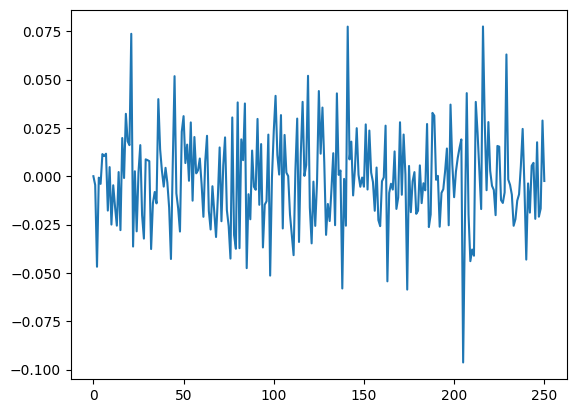

In [33]:
pd.read_csv('stock_data/GOOG.csv')['% change'].plot() # Google's daily returns plot

A dataframe of S&P 500 tickers is scraped from a wikipedia article:

In [34]:
# Get dataframe of tickers in the S&P500 index
snp_ticker_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0][['Symbol']]

In [35]:
snp_ticker_list['Symbol']

0       MMM
1       AOS
2       ABT
3      ABBV
4       ACN
       ... 
498     YUM
499    ZBRA
500     ZBH
501    ZION
502     ZTS
Name: Symbol, Length: 503, dtype: object

Then I isolate the S&P 500 tickers I managed to download (and managed to fill in missing data):

In [36]:
exists = []
for i in snp_ticker_list['Symbol']:
    print(i)
    if os.path.exists(f'stock_data/{i}.csv'):
        exists += [i]

MMM
AOS
ABT
ABBV
ACN
ATVI
ADM
ADBE
ADP
AAP
AES
AFL
A
APD
AKAM
ALK
ALB
ARE
ALGN
ALLE
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
AMD
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APH
ADI
ANSS
AON
APA
AAPL
AMAT
APTV
ACGL
ANET
AJG
AIZ
T
ATO
ADSK
AZO
AVB
AVY
AXON
BKR
BALL
BAC
BBWI
BAX
BDX
WRB
BRK.B
BBY
BIO
TECH
BIIB
BLK
BK
BA
BKNG
BWA
BXP
BSX
BMY
AVGO
BR
BRO
BF.B
BG
CHRW
CDNS
CZR
CPT
CPB
COF
CAH
KMX
CCL
CARR
CTLT
CAT
CBOE
CBRE
CDW
CE
CNC
CNP
CDAY
CF
CRL
SCHW
CHTR
CVX
CMG
CB
CHD
CI
CINF
CTAS
CSCO
C
CFG
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CMA
CAG
COP
ED
STZ
CEG
COO
CPRT
GLW
CTVA
CSGP
COST
CTRA
CCI
CSX
CMI
CVS
DHI
DHR
DRI
DVA
DE
DAL
XRAY
DVN
DXCM
FANG
DLR
DFS
DIS
DG
DLTR
D
DPZ
DOV
DOW
DTE
DUK
DD
DXC
EMN
ETN
EBAY
ECL
EIX
EW
EA
ELV
LLY
EMR
ENPH
ETR
EOG
EPAM
EQT
EFX
EQIX
EQR
ESS
EL
ETSY
EG
EVRG
ES
EXC
EXPE
EXPD
EXR
XOM
FFIV
FDS
FICO
FAST
FRT
FDX
FITB
FSLR
FE
FIS
FI
FLT
FMC
F
FTNT
FTV
FOXA
FOX
BEN
FCX
GRMN
IT
GEHC
GEN
GNRC
GD
GE
GIS
GM
GPC
GILD
GL
GPN
GS
HAL
HIG
HAS
HCA
PEAK
HSIC
HSY
HES
HPE
HLT
HOLX
HD
HON
HRL
HST


In [37]:
# These are the tickers that are in the S&P500, but for some reason, had to be dropped. We will disregard these to make the project easier
snp_ticker_list[~snp_ticker_list['Symbol'].isin(exists)]


,Symbol
4,ACN
26,AMCR
35,AMP
46,APTV
47,ACGL
65,BRK.B
81,BF.B
95,CBOE
108,CB
128,CEG


`snp_weights` is a list of the tickers' relative weights. As this is an Equal Weight Index, each stock has an equal weighting:

In [38]:
snp_weights = np.repeat(1/len(exists),len(exists)) # creating a list of weights, with each stock having equal weighting in this case

`snp_index` contains the daily returns of each stock in the index, on each trading day in 2022:

In [39]:
snp_index = pd.DataFrame()
for i in exists:
    snp_index[i] = pd.read_csv(f'stock_data/{i}.csv')['% change']


/tmp/ipykernel_22385/2738873249.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  snp_index[i] = pd.read_csv(f'stock_data/{i}.csv')['% change']
/tmp/ipykernel_22385/2738873249.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  snp_index[i] = pd.read_csv(f'stock_data/{i}.csv')['% change']
/tmp/ipykernel_22385/2738873249.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

The `index_returns` variable is added to `snp_index`, and this is the calculation of the index's returns on each trading day in 2022:

In [40]:
snp_index['index_returns'] = snp_index.mul(snp_weights,axis=1).sum(axis=1)
snp_index

/tmp/ipykernel_22385/1338705646.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  snp_index['index_returns'] = snp_index.mul(snp_weights,axis=1).sum(axis=1)


,MMM,AOS,ABT,ABBV,ATVI,ADM,ADBE,ADP,AAP,AES,...,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS,index_returns
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.014009,0.016633,-0.023518,-0.001920,-0.003263,0.018559,-0.018374,0.004672,0.001140,0.002871,...,0.020129,-0.003190,0.006329,0.010608,0.005347,0.006337,0.010145,0.028487,-0.038072,0.007644
2,-0.004106,-0.016714,-0.004493,0.005253,-0.013542,-0.007809,-0.071426,-0.008525,-0.002531,-0.045808,...,-0.023286,-0.037033,0.009800,-0.013629,-0.012677,-0.050068,-0.003297,0.002270,-0.038024,-0.015958
3,-0.008301,0.006703,-0.000148,-0.004710,-0.037260,0.008891,-0.000603,-0.006871,0.021992,-0.003858,...,0.003502,0.004629,-0.007821,-0.001373,0.010330,-0.005410,-0.008307,0.041075,0.003971,0.002502
4,0.010955,-0.011296,0.003108,-0.002588,0.003447,0.008523,-0.006652,-0.010564,-0.014732,-0.006024,...,-0.008802,-0.001063,0.008759,-0.007993,-0.011466,-0.043771,-0.006050,0.016681,-0.029114,-0.002296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,-0.011925,0.011915,0.001389,-0.001041,0.003303,0.012087,0.005735,0.007443,0.008446,0.013070,...,0.006644,-0.006401,0.012852,-0.000728,0.000621,0.002869,0.001106,0.003521,0.005033,0.006900
247,0.000666,0.013532,0.003605,-0.000674,-0.002107,0.013634,-0.009928,0.000374,0.012144,0.004881,...,0.000407,0.044723,0.009023,0.009022,0.007758,0.011200,0.004657,0.008050,-0.003156,0.000021
248,-0.016054,-0.015606,-0.006816,-0.004663,0.003431,-0.023877,-0.020174,-0.013193,0.001931,-0.017349,...,-0.014629,-0.050279,-0.007203,-0.016076,-0.004542,-0.016574,-0.010135,-0.017813,-0.010117,-0.013624
249,0.019275,0.015677,0.022999,0.002034,0.009336,-0.005341,0.028173,0.011646,0.006951,0.017302,...,0.009263,0.014609,0.007085,0.024784,0.005259,0.043307,0.014604,0.023139,0.030035,0.017664


The index returns are converted to cumulative returns to give the total returns through time

In [41]:
snp_index['cumulative returns'] = ((1+snp_index['index_returns']).cumprod()-1)

/tmp/ipykernel_22385/2344302105.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  snp_index['cumulative returns'] = ((1+snp_index['index_returns']).cumprod()-1)


And the result is plotted. The resulting plot is very similar to the actual S&P 500 EWI graph, indicating that the tickers that had to be excluded did not have a major effect on the final result.

<Axes: >

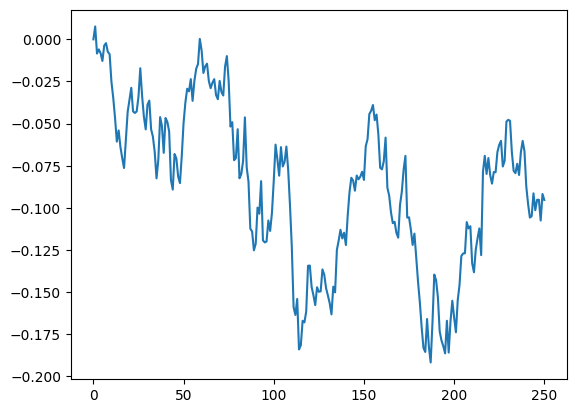

In [42]:
snp_index['cumulative returns'].plot()
# Quite close to actual graph but not perfect - year change is about 1 percentage point from the actual value

I then follow the same steps to create the actual S&P 500 (weighted) index:

/tmp/ipykernel_22385/2307594685.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mktcap = float(us_stocks[us_stocks['Symbol']==i]['Market Cap'])
/tmp/ipykernel_22385/2307594685.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  snp_index['index_returns'] = snp_index.mul(snp_weights,axis=1).sum(axis=1)
/tmp/ipykernel_22385/2307594685.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  snp_index['cumulative returns'] = ((1+snp_in

<Axes: >

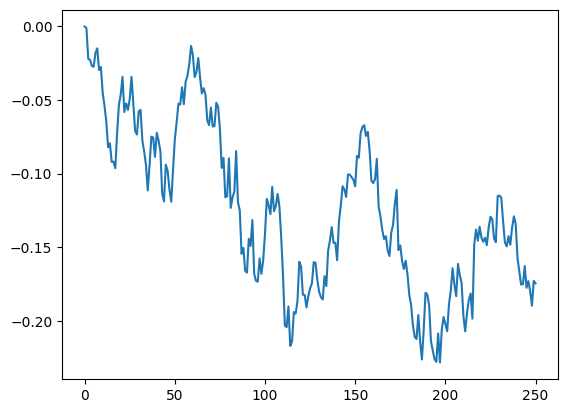

In [43]:
# To create a market cap weighted index
snp_weights = []
for i in exists:
    mktcap = float(us_stocks[us_stocks['Symbol']==i]['Market Cap'])
    snp_weights += [mktcap/us_stocks[us_stocks['Symbol'].isin(exists)]['Market Cap'].sum()]
snp_index.drop(['index_returns','cumulative returns'], axis=1, inplace=True)
snp_index['index_returns'] = snp_index.mul(snp_weights,axis=1).sum(axis=1)
snp_index['cumulative returns'] = ((1+snp_index['index_returns']).cumprod()-1)
snp_index['cumulative returns'].plot()

In [44]:
snp_index['cumulative returns'].iloc[250] # actual return is -0.1944, so this one is about 2 percentage points from the actual

-0.17458237461786186

### Next Step: making an index of each industries in the US

In [45]:
sectors

0     Communication Services
1     Consumer Discretionary
2           Consumer Staples
3                     Energy
4                 Financials
5                 Healthcare
6                Industrials
7     Information Technology
8                  Materials
9                Real Estate
10                 Utilities
Name: Sector, dtype: object

In [46]:
# compute the different weights of each industry based on market capitalisation
industry_weights = {}
for i in sectors:
    weights = []
    industry_tickers = list(us_stocks[us_stocks['Sector'] == i]['Symbol'])

    for j in industry_tickers:
        market_cap = float(us_stocks[us_stocks['Symbol']==j]['Market Cap'])
        weights += [market_cap/us_stocks[us_stocks['Symbol'].isin(industry_tickers)]['Market Cap'].sum()]
    industry_weights[i] = weights

/tmp/ipykernel_22385/2589892334.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  market_cap = float(us_stocks[us_stocks['Symbol']==j]['Market Cap'])


In [47]:
# Compute the cumulative returns of all sectors
industry_return_data = pd.DataFrame()
for i in sectors:
    return_data = pd.DataFrame()
    industry_tickers = list(us_stocks[us_stocks['Sector'] == i]['Symbol'])
    for j in industry_tickers:
        return_data[j] = pd.read_csv(f'stock_data/{j}.csv')['% change']
    return_data['index_returns'] = return_data.mul(industry_weights[i],axis=1).sum(axis=1)
    return_data['cumulative returns'] = ((1+return_data['index_returns']).cumprod()-1)
    industry_return_data[i] = return_data['cumulative returns'] # this is all we need. We can throw out the rest

/tmp/ipykernel_22385/2942352652.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return_data[j] = pd.read_csv(f'stock_data/{j}.csv')['% change']
/tmp/ipykernel_22385/2942352652.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return_data[j] = pd.read_csv(f'stock_data/{j}.csv')['% change']
/tmp/ipykernel_22385/2942352652.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

<Axes: >

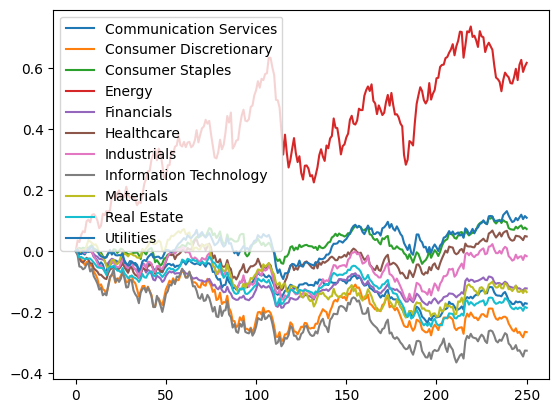

In [48]:
industry_return_data.plot()